# Explore a trained model

This notebook explores some of the things we can plot and analyze with a fully trained model.

Note that this model is coarsely trained - it is not our best effort!

In [66]:
path_to_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_tester/'

# Configuration

In [67]:
import json
with open(path_to_model+'configuration.json') as f:
    config=json.load(f)
    display(config['train'])

{'training_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2016_ML.parquet',
 'validation_data': '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/joined_data/2017_ML.parquet',
 'training_features': ['sp',
  'msl',
  'u10',
  'v10',
  't2m',
  'aluvp',
  'aluvd',
  'alnip',
  'alnid',
  'istl1',
  'istl2',
  'sd',
  'd2m',
  'fal',
  'skt',
  'slt_v15',
  'sdfor_v15',
  'sdor_v15',
  'cvl_v15',
  'lsm_v15',
  'isor_v15',
  'tvl_v15',
  'tvh_v15',
  'cvh_v15',
  'si10_v15',
  'anor_v15',
  'cl_v15',
  'dl_v15',
  'z_v15',
  'slor_v15',
  'sdor_v20',
  'cvl_v20',
  'lsm_v20',
  'isor_v20',
  'cvh_v20',
  'si10_v20',
  'anor_v20',
  'cl_v20',
  'dl_v20',
  'z_v20',
  'slor_v20'],
 'batch_size': 10000,
 'epochs': 200,
 'number_of_hidden_layers': 3,
 'nodes_per_layer': [None, None, None],
 'target_variable': 'MODIS_LST',
 'learning_rate': 0.001,
 'loss': 'mse',
 'metrics': ['accuracy'],
 'path_t

# Training history

Number of epochs: 124
Minimum training loss: 16.704124450683594
Minimum validation loss: 16.55333137512207


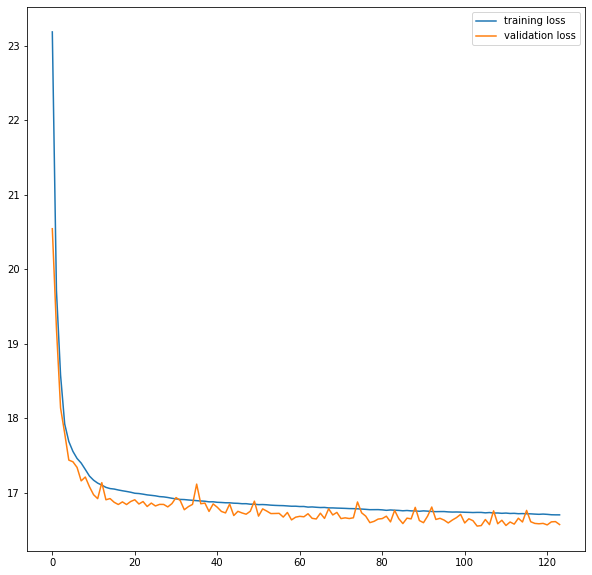

In [68]:
import numpy as np
import matplotlib.pyplot as plt
with open(path_to_model+'training_history.json') as f:
    d = json.load(f)

    training_loss = d['loss'][1:]
    validation_loss = d['val_loss'][1:]
    epochs = np.arange(len(training_loss))
    print ('Number of epochs:', len(epochs))
    print ('Minimum training loss:', min(training_loss))
    print('Minimum validation loss:', min(validation_loss))

    fig = plt.figure(figsize=(10, 10))
    plt.plot(epochs,training_loss,label='training loss')
    plt.plot(epochs,validation_loss, label='validation loss')
    plt.legend()
        


# Predictions

In [69]:
import pandas as pd
def load_predictions(path):

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_predicion_bias'] = df.MODIS_LST - df.predictions
    df['model_predicion_error'] = abs(df.MODIS_LST - df.predictions)
    
    
    df['ERA_predicion_bias'] = df.MODIS_LST - df.skt_unnormalised
    df['ERA_predicion_error'] = abs(df.MODIS_LST - df.skt_unnormalised)


    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_predicion_bias'].mean(), df['model_predicion_bias'].median(),df['model_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['model_predicion_error'].mean(), df['model_predicion_error'].median(),df['model_predicion_error'].std())
    print ('------------------------------------ERA---------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['ERA_predicion_bias'].mean(), df['ERA_predicion_bias'].median(),df['ERA_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['ERA_predicion_error'].mean(), df['ERA_predicion_error'].median(),df['ERA_predicion_error'].std())
    print ('-------------------------------------------------------------------------------------------')

    
    return df

from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 


def plot_map(ds,z,vmin,vmax,cmap,absolute_values,logscale,title,limits,markersize):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    if absolute_values:
        z1 = abs(z1)
        if vmin < 0:
            vmin = 0 # dont need negative vmins if plotting absolute values

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)
    
    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
        

In [70]:
predictions = load_predictions(path_to_model)
yearly_averaged_predictions = predictions.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean()

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.071762495 0.20736694 4.053956
Mean/Median/Std prediction error: 3.018743 2.3042297 2.7068226
------------------------------------ERA---------------------------------------------------
Mean/Median/Std prediction bias: -0.4853097 -0.5901489 5.1987367
Mean/Median/Std prediction error: 3.8696697 2.973236 3.5054328
-------------------------------------------------------------------------------------------


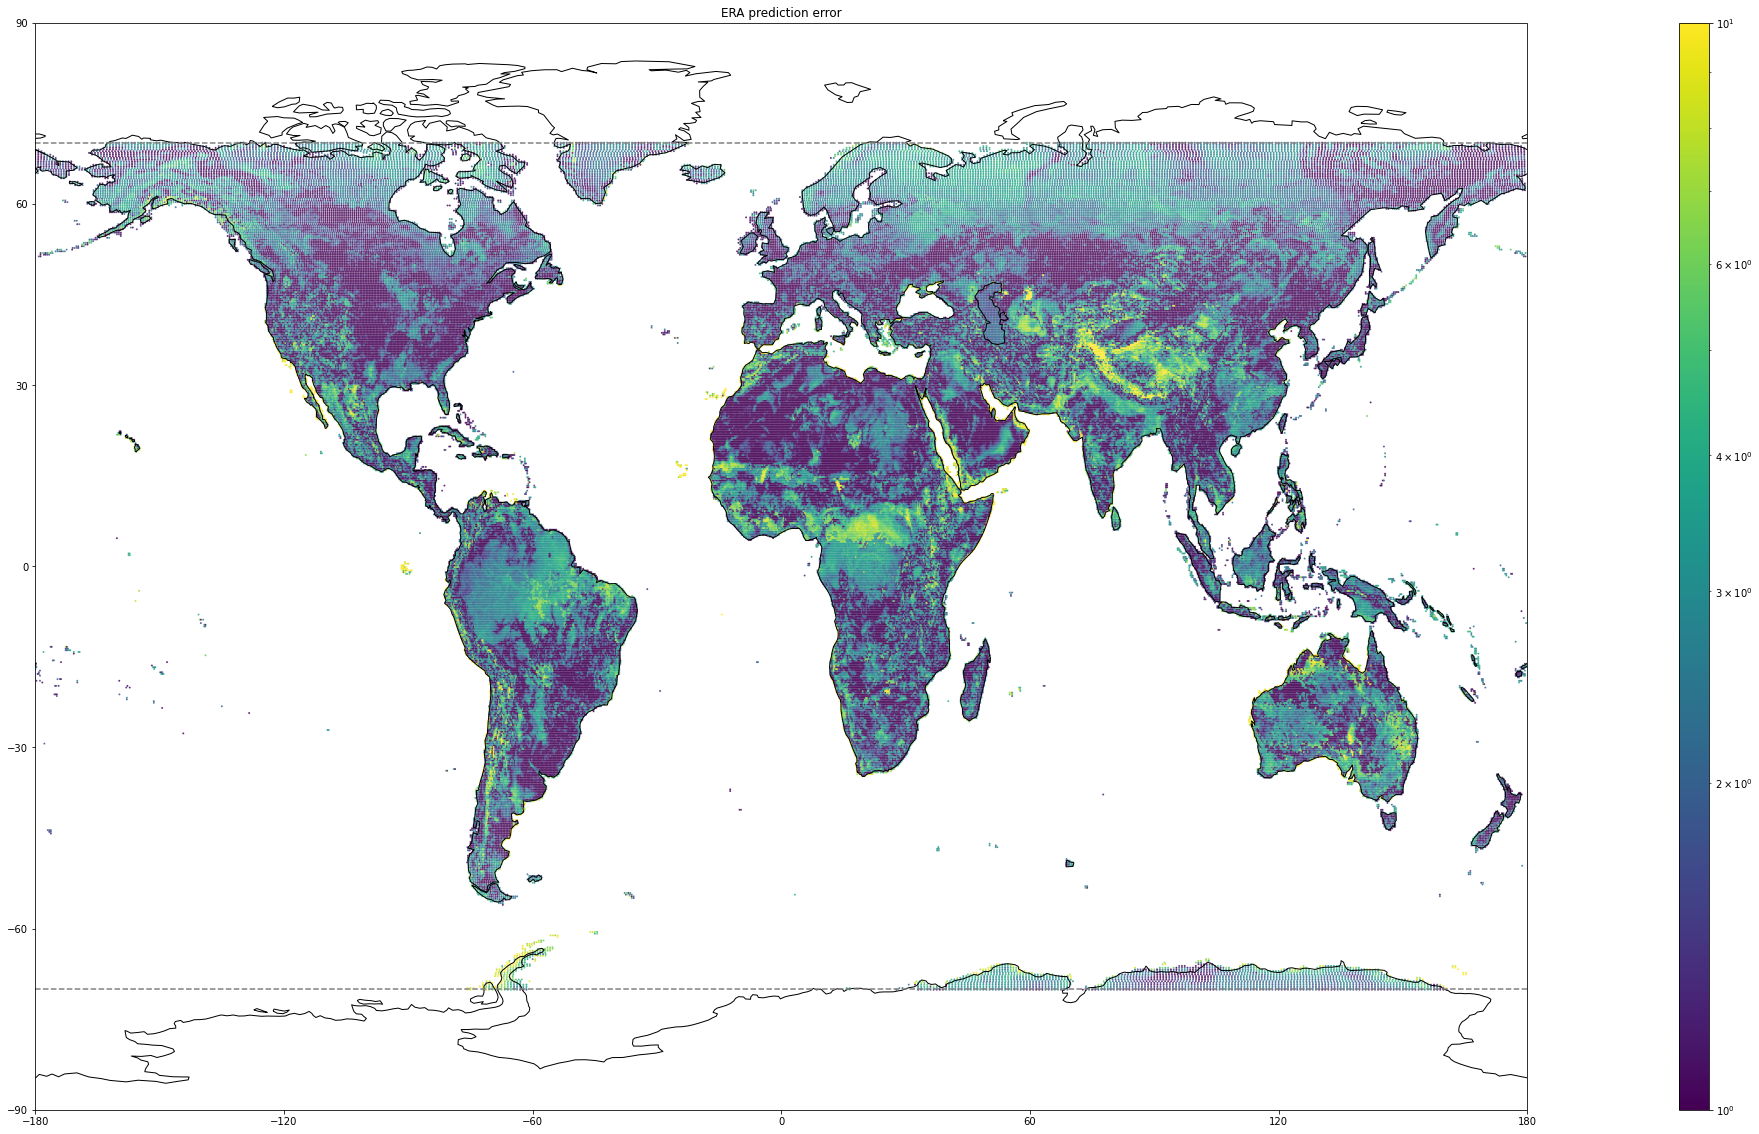

In [73]:
#Plot a map of the error in the ERA skt 
plot_map(yearly_averaged_predictions,
         'ERA_predicion_bias',
         vmin=1,vmax=10,
         cmap=plt.cm.viridis,
         absolute_values = False,
         logscale=True,
         title='ERA prediction error',
         limits=None,
         markersize=1)

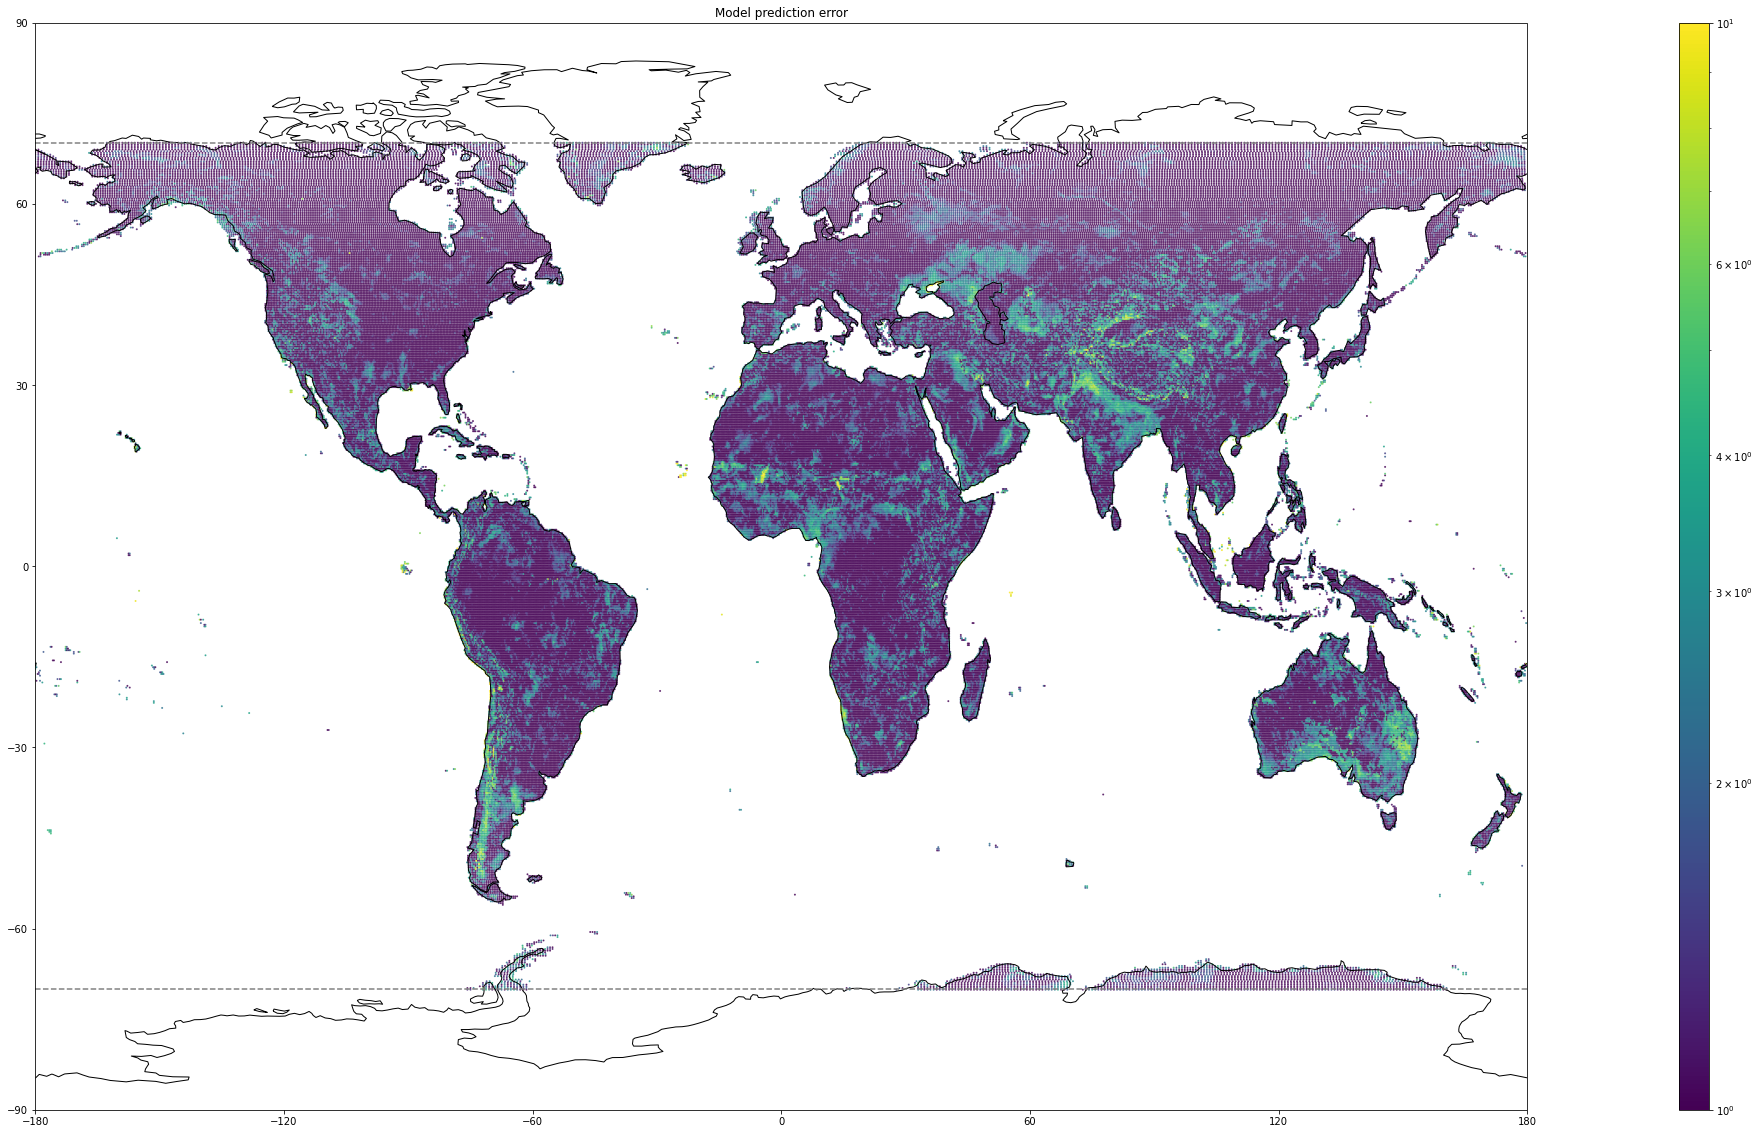

In [74]:
#Plot a map of the error in the model predictions
plot_map(yearly_averaged_predictions,
         'model_predicion_bias',
         vmin=1,vmax=10,
         cmap=plt.cm.viridis,
         absolute_values = False,
         logscale=True,
         title='Model prediction error',
         limits=None,
         markersize=1)


# Histogram of errors

    


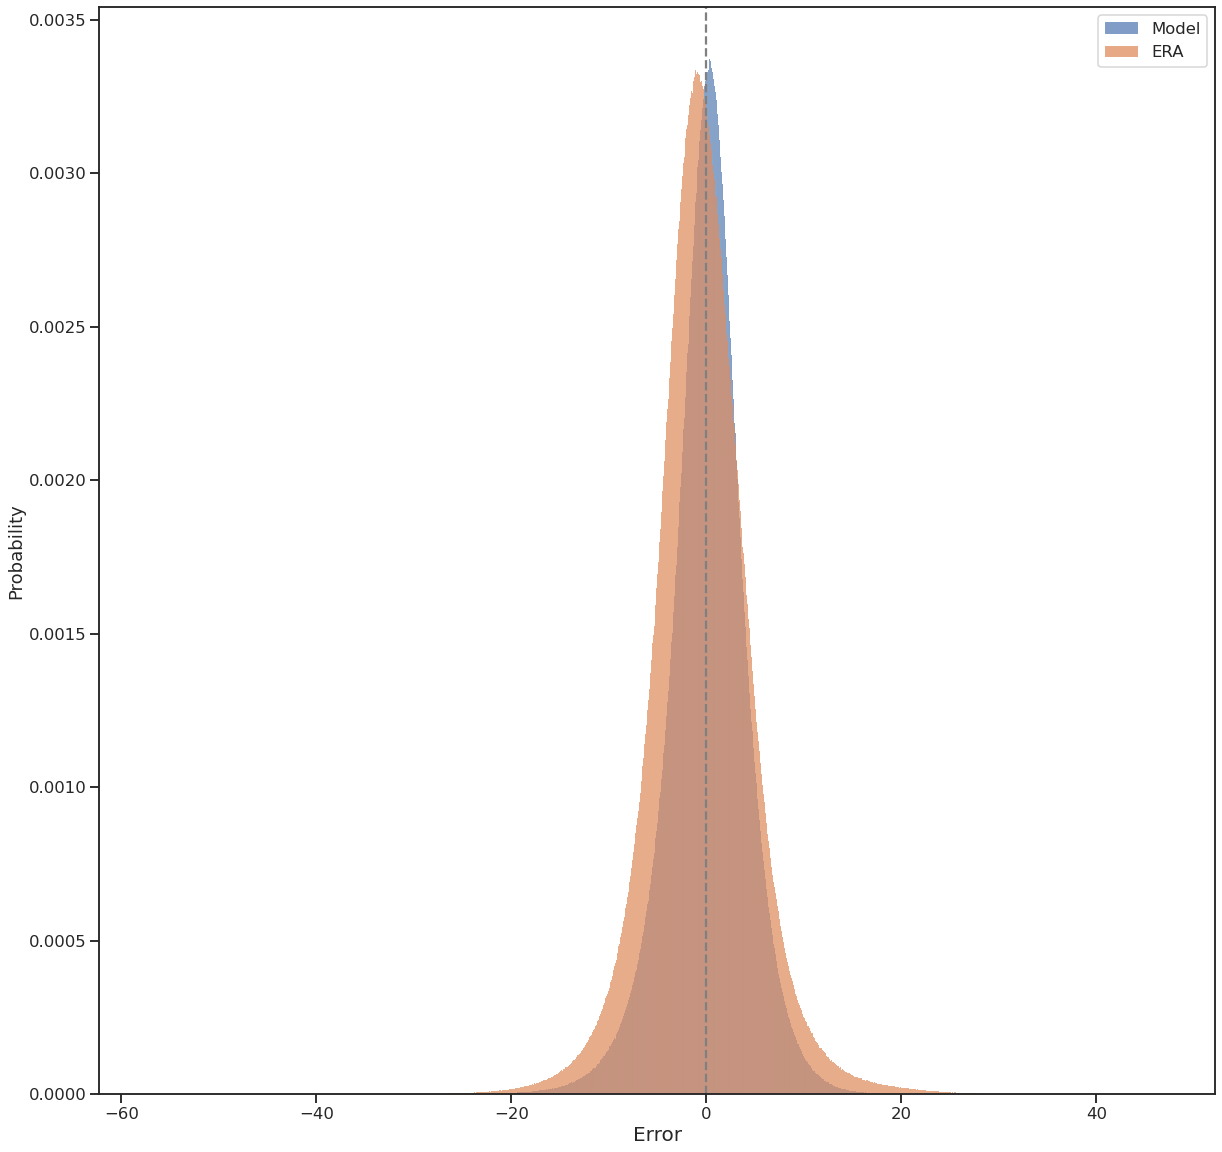

CPU times: user 1min 58s, sys: 8.7 s, total: 2min 7s
Wall time: 2min 11s


In [75]:
%%time


import seaborn as sns
#Plot distribution of errors
#This is quite slow, ~1-2 mins

#Setup plot env
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )


#Figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))






sns.histplot(predictions['model_predicion_bias'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C0',label='Model')
sns.histplot(predictions['ERA_predicion_bias'], bins='auto', ax=ax1,stat='probability',kde=False,alpha=0.7,color='C1',label='ERA')

# Config
ax1.set_xlabel('Error', fontsize = 20)
ax1.legend().set_title(None)
ax1.axvline(0,c='0.5', linestyle='--')




plt.show()


---